In [16]:
import numpy as np
import pandas as pd
import torch
import h5py
import re
import torch.nn as nn 
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [2]:
import numpy as np
import h5py
import torch

smoke_detectors = np.array([[60.0, 60.0],[30.0, 80.0]])

# Initialize lists to store tensors for source positions, density values, and class labels
source_positions_tensors = []
density_values_tensors = []
class_tensors = []

# Initialize tensors for source positions and density values
source_positions_tensor = None
density_values_tensor = None
class_tensor = None

# Open the HDF5 file in read mode
with h5py.File("Smoke Flow Data.h5", "r") as hf:

    # Iterate over each smoke detector position
    for smoke_detector_pos in smoke_detectors:
        x, y = smoke_detector_pos
        
        # Iterate over the time steps with a sliding window
        for source_group_name in hf:
            total_steps = 501  # Total number of steps
            window_size = 300
            # Access the group corresponding to the source position
            source_group = hf[source_group_name]

            # Extract the source position value from the group name
            source_position_str = source_group_name.split('-')[-1]

            # Convert the source position string to a numerical data type (e.g., float)
            source_position = float(source_position_str)

            # Access the 'density' dataset within the group
            density_dataset = source_group['density']

            # Iterate over the sliding windows
            for start_idx in range(total_steps - window_size):
                # Retrieve the density values at the specified position (x, y) for the current window
                density_values_at_position = density_dataset[start_idx : start_idx + window_size, int(x), int(y), 0]
                
                # Convert density values to PyTorch tensor
                density_values_tensor_batch = torch.tensor(density_values_at_position)
                source_position_tensor_batch = torch.tensor(source_position)
                
                # Calculate the class label based on the source position
                class_label = int(source_position // 10) - 1
                # print(class_label)

                # Create class tensor based on the class label
                class_tensor_batch = torch.tensor(class_label)

                # Concatenate batch tensors
                if source_positions_tensor is None:
                    source_positions_tensor = source_position_tensor_batch.unsqueeze(0)
                    density_values_tensor = density_values_tensor_batch.unsqueeze(0)
                    class_tensor = class_tensor_batch.unsqueeze(0)
                else:
                    source_positions_tensor = torch.cat((source_positions_tensor, source_position_tensor_batch.unsqueeze(0)), dim=0)
                    density_values_tensor = torch.cat((density_values_tensor, density_values_tensor_batch.unsqueeze(0)), dim=0)
                    class_tensor = torch.cat((class_tensor, class_tensor_batch.unsqueeze(0)), dim=0)

            # Append the tensors to the lists after processing all sliding windows for each source position
            source_positions_tensors.append(source_positions_tensor)
            density_values_tensors.append(density_values_tensor)
            class_tensors.append(class_tensor)

# You now have the source positions, density values, and class labels as tensors with sliding windows
print("Source positions tensor shape:", source_positions_tensor.shape)
print("Density values tensor shape:", density_values_tensor.shape)
print("Class tensor shape:", class_tensor.shape)


Source positions tensor shape: torch.Size([3618])
Density values tensor shape: torch.Size([3618, 300])
Class tensor shape: torch.Size([3618])


In [3]:
density_tensor = density_values_tensor.reshape(1809,2,-1)
source_tensor = source_positions_tensor.view(1809,-1)
class_tensor = class_tensor.view(1809,-1)

In [4]:
class_tensor[~(class_tensor[:,0] == class_tensor[:,1])]
class_tensor = class_tensor[:,0]

In [5]:
print("Source positions tensor shape:", source_tensor.shape)
print("Density values tensor shape:", density_tensor.shape)
print("Class tensor shape:", class_tensor.shape)


Source positions tensor shape: torch.Size([1809, 2])
Density values tensor shape: torch.Size([1809, 2, 300])
Class tensor shape: torch.Size([1809])


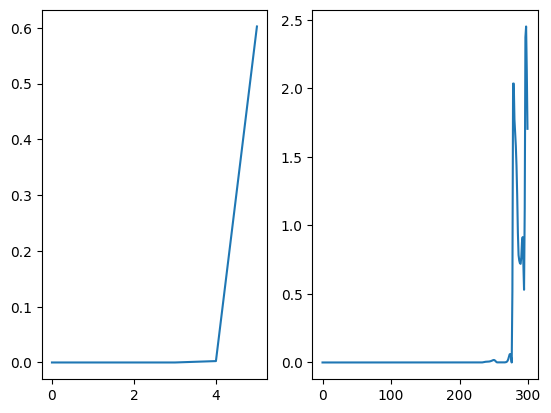

In [6]:
### Just checking how averaging might work on the singal

# import torch.nn as nn
my_test_layer = nn.AvgPool1d(50)
plt.subplot(121)
plt.plot(my_test_layer(density_tensor)[100,0,:])
plt.subplot(122)
plt.plot((density_tensor)[100,0,:])



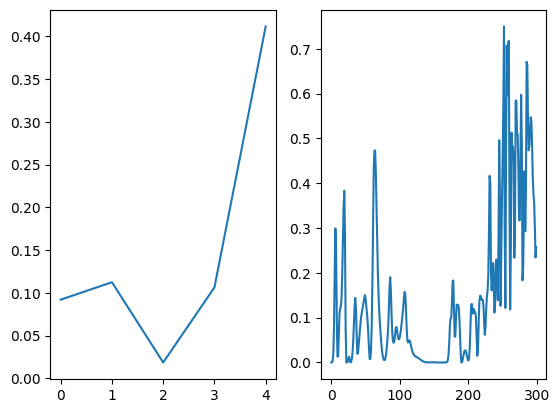

In [7]:
## Just checking how averaging might work on the singalf
my_test_layer2 = nn.AvgPool1d(60)
plt.subplot(121)
plt.plot(my_test_layer2(density_tensor)[500,0,:])
plt.subplot(122)
plt.plot((density_tensor)[500,0,:])



In [8]:
# torch.unique(class_tensor, dim=0)

In [9]:
num_samples = len(density_tensor)
print(num_samples)
split_ratio = 0.8
split_index = int(split_ratio * num_samples)
print(split_index)

1809
1447


In [10]:
train_density = density_tensor[:split_index]
test_density = density_tensor[split_index:]
train_source = class_tensor[:split_index]
test_source = class_tensor[split_index:]
print(len(test_source))

362


In [11]:
batch_size = 16

# Create DataLoader for training set
train_dataset = TensorDataset(train_density, train_source)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for testing set
test_dataset = TensorDataset(test_density, test_source)
print(len(test_dataset))
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True, drop_last=True)
print(len(test_loader))


362
22


In [12]:
# X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
# # Create DataLoader for training and testing
# train_dataset = TensorDataset(X_train, y_train)
# test_dataset = TensorDataset(X_test, y_test)

# train_loader = DataLoader(train_dataset, batch_size= 128, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size= 128, shuffle=False)

In [13]:

# class SimpleCNN(nn.Module):
#     def __init__(self, num_classes):
#         super(SimpleCNN, self).__init__()

#         self.avgpool1 = nn.AvgPool1d(50)
#         self.avgpool2 = nn.AvgPool1d(40)
#         self.avgpool3 = nn.AvgPool1d(60)
        
#         self.conv1 = nn.Conv1d(in_channels=2, out_channels=16, kernel_size=3, stride=1, padding=1)
#         self.relu1 = nn.ReLU()
        
#         self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
#         self.relu2 = nn.ReLU()
        
#         self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
#         self.fc1 = nn.Linear(576,num_classes)  # Adjusted based on the output size after convolutions
#         self.relu3 = nn.ReLU()
        
#         self.fc2 = nn.Linear(128, num_classes)

#     def forward(self, x):

#         # Apply the average pooling layers
#         x1 = self.avgpool1(x)
#         # if self.debug:
#         # print("Size before reshaping 1:", x1.size())
        
#         x2 = self.avgpool2(x)
#         # if self.debug:
#         # print("Size before reshaping 2:", x2.size())
        
#         x3 = self.avgpool3(x)
#         # if self.debug:
#         # print("Size before reshaping 3:", x3.size())

#         # Concatenate the outputs from the average pooling layers
#         x = torch.cat((x1, x2, x3),dim = 2)
#         # if self.debug:
#         # print("Size before reshaping final concated:", x_concat.size())

        
#         x = self.conv1(x)
#         x = self.relu1(x)
        
#         # x = self.pool(x)
#         x = self.conv2(x)
#         x = self.relu2(x)
        
        # # x = self.pool(x)
        # # print(x.shape)
        
        # x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        # # print("Linear",x.shape)
        
        # x = self.fc1(x)
        # # print("brefore", x.shape)
        
        # x = self.relu3(x)
        # # print("after Reul",x.shape) 
        
        # # x = self.fc2(x)
        # x = F.softmax(x, dim=1)  # Apply softmax activation to output
        
        # return x





class SimpleCNN(nn.Module):
    def __init__(self, num_classes, debug=False):
        super(SimpleCNN, self).__init__()
        self.debug = debug  # Debug flag

        self.avgpool1 = nn.AvgPool1d(50)
        self.avgpool2 = nn.AvgPool1d(40)
        self.avgpool3 = nn.AvgPool1d(60)
        
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=16, kernel_size=5, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
        # self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(10112, num_classes)  # Adjusted based on the output size after convolutions
        self.relu3 = nn.ReLU()
        
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):

        # Apply the average pooling layers
        x1 = self.avgpool1(x)
        if self.debug:
            print("Size before reshaping 1:", x1.size())
        
        x2 = self.avgpool2(x)
        if self.debug:
            print("Size before reshaping 2:", x2.size())
        
        x3 = self.avgpool3(x)
        if self.debug:
            print("Size before reshaping 3:", x3.size())

        # Concatenate the outputs from the average pooling layers
        xcat = torch.cat((x, x1, x2, x3), dim=2)
        if self.debug:
            print("Size before reshaping final concatenated:", x.size())

        h = self.conv1(xcat)
        h = self.relu1(h)
        
        h = self.conv2(h)
        h = self.relu2(h)
        
        h = h.view(h.size(0), -1)  # Flatten the output for the fully connected layers
        
        h = self.fc1(h)
        
        
        return h


In [17]:
# model = SimpleCNN(num_classes=9)
model = SimpleCNN(num_classes=10, debug=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
# scheduler = StepLR(optimizer, step_size= .7, gamma = .9)


In [15]:

# class_indices = torch.argmax(outputs, dim=1)
# F.cross_entropy(outputs, labels)

NameError: name 'outputs' is not defined

In [18]:
num_epochs = 60
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        # print("This is output", outputs)
        
        # Convert one-hot encoded labels to class indices
        class_indices = torch.argmax(outputs, dim=1)
        # print("This is class ", class_indices)
        
        # Calculate the loss using cross entropy
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/60, Loss: 1.5560
Epoch 2/60, Loss: 1.4356
Epoch 3/60, Loss: 1.3513
Epoch 4/60, Loss: 0.9628
Epoch 5/60, Loss: 0.4886
Epoch 6/60, Loss: 0.7054
Epoch 7/60, Loss: 0.5380
Epoch 8/60, Loss: 0.2275
Epoch 9/60, Loss: 0.0109
Epoch 10/60, Loss: 0.0628
Epoch 11/60, Loss: 0.3670
Epoch 12/60, Loss: 0.3950
Epoch 13/60, Loss: 0.3193
Epoch 14/60, Loss: 0.0004
Epoch 15/60, Loss: 0.3540
Epoch 16/60, Loss: 0.1519
Epoch 17/60, Loss: 0.5206
Epoch 18/60, Loss: 0.1364
Epoch 19/60, Loss: 0.2284
Epoch 20/60, Loss: 0.0001
Epoch 21/60, Loss: 0.0001
Epoch 22/60, Loss: 0.1958
Epoch 23/60, Loss: 0.2233
Epoch 24/60, Loss: 0.1461
Epoch 25/60, Loss: 0.0016
Epoch 26/60, Loss: 0.1603
Epoch 27/60, Loss: 0.1309
Epoch 28/60, Loss: 0.2732
Epoch 29/60, Loss: 0.3081
Epoch 30/60, Loss: 0.0000
Epoch 31/60, Loss: 0.0000
Epoch 32/60, Loss: 0.0000
Epoch 33/60, Loss: 0.0000
Epoch 34/60, Loss: 0.0088
Epoch 35/60, Loss: 0.3468
Epoch 36/60, Loss: 0.0122
Epoch 37/60, Loss: 0.0053
Epoch 38/60, Loss: 0.2486
Epoch 39/60, Loss: 0.

In [19]:
# Evaluation loop
model.eval()  # Set model to evaluation mode
total_correct = 0
total_samples = 0
with torch.no_grad():
    for inputs, labels in test_loader:  # Assuming you have a separate DataLoader for testing/validation data
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim=1)
        # print("1",predicted)
        
        # Convert one-hot encoded labels to class indices
        # print(class_indices)
        # print(class_indices)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples
# print(accuary)
print(f"Accuracy on the test set: {accuracy:.4f}")

Accuracy on the test set: 0.1790


In [ ]:
labels

In [ ]:
predicted

In [117]:
### increasing the average pooling layers
### With  AvgPool4 - 23.5
## With AvgPool5 - 24
## with AvgPool6 - 26
#### with AvgPool7 - 32
### with AvgPoool8 - 16 
### with AvgPool9 - 21
### with Avgpool10 - 15


### To do - 
# Layer normalization - after relu1 all the way till relu3
# Try learning rate - diff

###Addign lower numeber has no good results
class SimpleCNN(nn.Module):
    def __init__(self, num_classes, debug=False):
        super(SimpleCNN, self).__init__()
        self.debug = debug  # Debug flag

        self.avgpool1 = nn.AvgPool1d(50)
        self.avgpool2 = nn.AvgPool1d(40)
        self.avgpool3 = nn.AvgPool1d(60)
        self.avgpool4 = nn.AvgPool1d(20)
        self.avgpool5 = nn.AvgPool1d(10)
        self.avgpool6 = nn.AvgPool1d(15)
        self.avgpool7 = nn.AvgPool1d(30)
        self.avgpool8 = nn.AvgPool1d(80)
        self.avgpool9 = nn.AvgPool1d(100)
        
        
        
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=16, kernel_size=5, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
        # self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(12512, num_classes)  # Adjusted based on the output size after convolutions
        self.relu3 = nn.ReLU()
        
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):

        # Apply the average pooling layers
        x1 = self.avgpool1(x)
        if self.debug:
            print("Size before reshaping 1:", x1.size())
        
        x2 = self.avgpool2(x)
        if self.debug:
            print("Size before reshaping 2:", x2.size())
        
        x3 = self.avgpool3(x)
        if self.debug:
            print("Size before reshaping 3:", x3.size())

        x4 = self.avgpool4(x)
        if self.debug:
            print("Size before reshaping 4:", x4.size())

        x5 = self.avgpool5(x)
        if self.debug:
            print("Size before reshaping 5:", x5.size())

        x6 = self.avgpool6(x)
        if self.debug:
            print("Size before reshaping 6:", x6.size())

        x7 = self.avgpool7(x)
        if self.debug:
            print("Size before reshaping 7:", x7.size())

        x8 = self.avgpool8(x)
        if self.debug:
            print("Size before reshaping 8:", x8.size())

        x9 = self.avgpool9(x)
        if self.debug:
            print("Size before reshaping 9:", x9.size())
            
        # Concatenate the outputs from the average pooling layers
        xcat = torch.cat((x, x1, x2, x3, x4,x5,x6,x7), dim=2)
        if self.debug:
            print("Size before reshaping final concatenated:", x.size())

        h = self.conv1(xcat)
        h = self.relu1(h)
        
        h = self.conv2(h)
        h = self.relu2(h)
        
        h = h.view(h.size(0), -1)  # Flatten the output for the fully connected layers
        
        h = self.fc1(h)
        
        
        return h

In [118]:
model = SimpleCNN(num_classes= 10, debug=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 60
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        # print("This is output", outputs)
        
        # Convert one-hot encoded labels to class indices
        class_indices = torch.argmax(outputs, dim=1)
        # print("This is class ", class_indices)
        
        # Calculate the loss using cross entropy
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/60, Loss: 2.1977
Epoch 2/60, Loss: 0.5712
Epoch 3/60, Loss: 0.2489
Epoch 4/60, Loss: 0.2035
Epoch 5/60, Loss: 0.2041
Epoch 6/60, Loss: 0.0041
Epoch 7/60, Loss: 0.1495
Epoch 8/60, Loss: 0.1805
Epoch 9/60, Loss: 0.1388
Epoch 10/60, Loss: 0.0496
Epoch 11/60, Loss: 0.0000
Epoch 12/60, Loss: 0.3847
Epoch 13/60, Loss: 0.2352
Epoch 14/60, Loss: 0.1380
Epoch 15/60, Loss: 0.1271
Epoch 16/60, Loss: 0.0002
Epoch 17/60, Loss: 0.0032
Epoch 18/60, Loss: 0.1310
Epoch 19/60, Loss: 0.1410
Epoch 20/60, Loss: 0.1477
Epoch 21/60, Loss: 0.1346
Epoch 22/60, Loss: 0.3844
Epoch 23/60, Loss: 0.0000
Epoch 24/60, Loss: 0.6370
Epoch 25/60, Loss: 0.6918
Epoch 26/60, Loss: 0.0007
Epoch 27/60, Loss: 0.3952
Epoch 28/60, Loss: 0.0080
Epoch 29/60, Loss: 0.0008
Epoch 30/60, Loss: 0.0000
Epoch 31/60, Loss: 0.1496
Epoch 32/60, Loss: 0.2404
Epoch 33/60, Loss: 0.1217
Epoch 34/60, Loss: 0.2664
Epoch 35/60, Loss: 0.0003
Epoch 36/60, Loss: 0.6060
Epoch 37/60, Loss: 0.1288
Epoch 38/60, Loss: 0.0001
Epoch 39/60, Loss: 0.

In [121]:
# Evaluation loop
model.eval()  # Set model to evaluation mode
total_correct = 0
total_samples = 0
with torch.no_grad():
    for inputs, labels in test_loader:  # Assuming you have a separate DataLoader for testing/validation data
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim=1)
        # print("1",predicted)
        
        # Convert one-hot encoded labels to class indices
        # print(class_indices)
        # print(class_indices)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples
# print(accuary)
print(f"Accuracy on the test set: {accuracy:.4f}")

Accuracy on the test set: 0.3239


In [148]:
### Increasing the average pool with increasing
### with Conv 3 and average pooling with 4,5,6 no improvements - goes down the hill
### with Conv 3 layers - 13%
## with conv 4 layers -  13%
### After relu1 layernormalization and so forth - to do 
## with conv 5 layers -  NAN nope

###Addign lower numeber has no good results
class SimpleCNNavg(nn.Module):
    def __init__(self, num_classes, debug=False):
        super(SimpleCNNavg, self).__init__()
        self.debug = debug  # Debug flag

        self.avgpool1 = nn.AvgPool1d(50)
        self.avgpool2 = nn.AvgPool1d(40)
        self.avgpool3 = nn.AvgPool1d(60)
        self.avgpool4 = nn.AvgPool1d(20)
        self.avgpool5 = nn.AvgPool1d(10)
        self.avgpool6 = nn.AvgPool1d(15)
        self.avgpool7 = nn.AvgPool1d(30)
        self.avgpool8 = nn.AvgPool1d(80)
        self.avgpool9 = nn.AvgPool1d(100)
        
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=16, kernel_size=5, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv1d(in_channels= 32, out_channels= 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv1d(in_channels= 64, out_channels= 128, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()

        self.conv5 = nn.Conv1d(in_channels= 128, out_channels = 256 , kernel_size=3, stride=1, padding=1)
        self.relu5 = nn.ReLU()
        
        self.fc1 = nn.Linear(80896, num_classes)  # Adjusted based on the output size after convolutions
        self.relu3 = nn.ReLU()
        
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):

        # Apply the average pooling layers
        x1 = self.avgpool1(x)
        if self.debug:
            print("Size before reshaping 1:", x1.size())
        
        x2 = self.avgpool2(x)
        if self.debug:
            print("Size before reshaping 2:", x2.size())
        
        x3 = self.avgpool3(x)
        if self.debug:
            print("Size before reshaping 3:", x3.size())

        x4 = self.avgpool4(x)
        if self.debug:
            print("Size before reshaping 4:", x4.size())

        x5 = self.avgpool5(x)
        if self.debug:
            print("Size before reshaping 5:", x5.size())

        x6 = self.avgpool6(x)
        if self.debug:
            print("Size before reshaping 6:", x6.size())

        x7 = self.avgpool7(x)
        if self.debug:
            print("Size before reshaping 7:", x7.size())

        x8 = self.avgpool8(x)
        if self.debug:
            print("Size before reshaping 8:", x8.size())

        x9 = self.avgpool9(x)
        if self.debug:
            print("Size before reshaping 9:", x9.size())
            
        # Concatenate the outputs from the average pooling layers
        xcat = torch.cat((x, x1, x2, x3), dim=2)
        if self.debug:
            print("Size before reshaping final concatenated:", x.size())

        h = self.conv1(xcat)
        h = self.relu1(h)
        
        h = self.conv2(h)
        h = self.relu2(h)

        h = self.conv3(h)
        h = self.relu3(h)

        h = self.conv4(h)
        h = self.relu4(h)

        h = self.conv5(h)
        h = self.relu5(h)
        
        h = h.view(h.size(0), -1)  # Flatten the output for the fully connected layers
        
        h = self.fc1(h)
        
        
        return h

In [149]:
model = SimpleCNNavg(num_classes= 10, debug=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 60
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        # print("This is output", outputs)
        
        # Convert one-hot encoded labels to class indices
        class_indices = torch.argmax(outputs, dim=1)
        # print("This is class ", class_indices)
        
        # Calculate the loss using cross entropy
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/60, Loss: 2.0331
Epoch 2/60, Loss: 1.9690
Epoch 3/60, Loss: 2.0339
Epoch 4/60, Loss: 2.3862
Epoch 5/60, Loss: 2.1413
Epoch 6/60, Loss: 2.1251
Epoch 7/60, Loss: 2.0437
Epoch 8/60, Loss: 2.2830
Epoch 9/60, Loss: 2.1866
Epoch 10/60, Loss: 2.1318
Epoch 11/60, Loss: 2.1815
Epoch 12/60, Loss: 2.1225
Epoch 13/60, Loss: 1.9810
Epoch 14/60, Loss: 2.1824
Epoch 15/60, Loss: 1.9742
Epoch 16/60, Loss: 1.9760
Epoch 17/60, Loss: 2.0789
Epoch 18/60, Loss: 2.2420
Epoch 19/60, Loss: 2.0790
Epoch 20/60, Loss: 2.2742
Epoch 21/60, Loss: 2.0785
Epoch 22/60, Loss: 2.0268
Epoch 23/60, Loss: 2.2243
Epoch 24/60, Loss: 2.2243
Epoch 25/60, Loss: 1.9825
Epoch 26/60, Loss: 2.2229
Epoch 27/60, Loss: 2.0836
Epoch 28/60, Loss: 1.9818
Epoch 29/60, Loss: 2.0298
Epoch 30/60, Loss: 2.0756
Epoch 31/60, Loss: 2.1813
Epoch 32/60, Loss: 2.0676
Epoch 33/60, Loss: 1.9900
Epoch 34/60, Loss: 2.2275
Epoch 35/60, Loss: 2.2733
Epoch 36/60, Loss: 2.3307
Epoch 37/60, Loss: 2.1186
Epoch 38/60, Loss: 2.3164
Epoch 39/60, Loss: 2.

In [150]:
# Evaluation loop
model.eval()  # Set model to evaluation mode
total_correct = 0
total_samples = 0
with torch.no_grad():
    for inputs, labels in test_loader:  # Assuming you have a separate DataLoader for testing/validation data
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim=1)
        # print("1",predicted)
        
        # Convert one-hot encoded labels to class indices
        # print(class_indices)
        # print(class_indices)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples
# print(accuary)
print(f"Accuracy on the test set: {accuracy:.4f}")

Accuracy on the test set: 0.0000


In [243]:
### Increasing the Linear layers
### With 128 normal - average pooling and conv 2 - 32%
## With 256 normal -  17%
### with 256 from best Average pooloing - 30%
### with 512 normal -  18%
### wtth 512 from best Average pooliong - 17%
### with 512 from best Average pooling and conv 4 layers - 31
### with 512 from best Average pooling and conv 5 layers - 22.4
### with 256 from best Average pooling and conv 4 layers  - 22.4

###Addign lower numeber has no good results
class SimpleCNNLin(nn.Module):
    def __init__(self, num_classes, debug=False):
        super(SimpleCNNLin, self).__init__()
        self.debug = debug  # Debug flag

        self.avgpool1 = nn.AvgPool1d(50)
        self.avgpool2 = nn.AvgPool1d(40)
        self.avgpool3 = nn.AvgPool1d(60)
        self.avgpool4 = nn.AvgPool1d(20)
        self.avgpool5 = nn.AvgPool1d(10)
        self.avgpool6 = nn.AvgPool1d(15)
        self.avgpool7 = nn.AvgPool1d(30)
        self.avgpool8 = nn.AvgPool1d(80)
        self.avgpool9 = nn.AvgPool1d(100)
        
        
        
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=16, kernel_size=5, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.norm1 = nn.BatchNorm1d(16)
        
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.norm2 = nn.BatchNorm1d(32)
        
        self.conv3 = nn.Conv1d(in_channels= 32, out_channels= 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.norm3 = nn.BatchNorm1d(64)

        self.conv4 = nn.Conv1d(in_channels= 64, out_channels= 128, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()

        self.conv5 = nn.Conv1d(in_channels= 128, out_channels = 256 , kernel_size=3, stride=1, padding=1)
        self.relu5 = nn.ReLU()
        
        self.fc1 = nn.Linear(2912 , num_classes)  # Adjusted based on the output size after convolutions
        self.relu3 = nn.ReLU()
        
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):

        # Apply the average pooling layers
        x1 = self.avgpool1(x)
        if self.debug:
            print("Size before reshaping 1:", x1.size())
        
        x2 = self.avgpool2(x)
        if self.debug:
            print("Size before reshaping 2:", x2.size())
        
        x3 = self.avgpool3(x)
        if self.debug:
            print("Size before reshaping 3:", x3.size())

        x4 = self.avgpool4(x)
        if self.debug:
            print("Size before reshaping 4:", x4.size())

        x5 = self.avgpool5(x)
        if self.debug:
            print("Size before reshaping 5:", x5.size())

        x6 = self.avgpool6(x)
        if self.debug:
            print("Size before reshaping 6:", x6.size())

        x7 = self.avgpool7(x)
        if self.debug:
            print("Size before reshaping 7:", x7.size())

        x8 = self.avgpool8(x)
        if self.debug:
            print("Size before reshaping 8:", x8.size())

        x9 = self.avgpool9(x)
        if self.debug:
            print("Size before reshaping 9:", x9.size())
            
        # Concatenate the outputs from the average pooling layers
        xcat = torch.cat(( x1, x2, x3,x4,x5,x6,x7), dim=2)
        if self.debug:
            print("Size before reshaping final concatenated:", x.size())

        h = self.conv1(xcat)
        if self.debug:
            print("Size After conv1 concatenated:", h.size())
        h = self.relu1(h)
        if self.debug:
            print("Size before reshaping final concatenated:", h.size())
        h = self.norm1(h)
        
        h = self.conv2(h)
        if self.debug:
            print("Size After conv2 concatenated:", h.size())
        h = self.relu2(h)
        if self.debug:
            print("Size After reul2 concatenated:", h.size())
        h = self.norm2(h)

        # h = self.conv3(h)
        # h = self.relu3(h)
        # h = self.norm3(h)

        # h = self.conv4(h)
        # h = self.relu4(h)

        # h = self.conv5(h)
        # h = self.relu5(h)
        
        h = h.view(h.size(0), -1)  # Flatten the output for the fully connected layers
        if self.debug:
            print("Size After Linear1 concatenated:", h.size())
            
        h = self.fc1(h)
        if self.debug:
            print("Size After Linear2 concatenated:", h.size())
        
        
        return h

In [244]:
model = SimpleCNNLin(num_classes= 10, debug= False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 60
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        # print("This is output", outputs)
        
        # Convert one-hot encoded labels to class indices
        class_indices = torch.argmax(outputs, dim=1)
        # print("This is class ", class_indices)
        
        # Calculate the loss using cross entropy
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, labels in test_loader:  # Assuming you have a separate DataLoader for testing/validation data
        
                outputs = model(inputs)
                _, predicted = torch.max(outputs, dim=1)
                total_correct += (predicted == labels).sum().item()
                total_samples += labels.size(0)

        accuracy = total_correct / total_samples

    # print(f"Accuracy on the test set: {accuracy:.4f}")
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f},Accuracy : {accuracy:.4f}")
    

Epoch 1/60, Loss: 0.9331,Accuracy : 0.2131
Epoch 2/60, Loss: 2.4153,Accuracy : 0.1136
Epoch 3/60, Loss: 1.2158,Accuracy : 0.1165
Epoch 4/60, Loss: 0.1282,Accuracy : 0.2386
Epoch 5/60, Loss: 0.0086,Accuracy : 0.0994
Epoch 6/60, Loss: 0.0099,Accuracy : 0.1080
Epoch 7/60, Loss: 0.3279,Accuracy : 0.0710
Epoch 8/60, Loss: 0.0074,Accuracy : 0.1761
Epoch 9/60, Loss: 0.0256,Accuracy : 0.0824


KeyboardInterrupt: 

In [227]:
# Evaluation loop
model.eval()  # Set model to evaluation mode
total_correct = 0
total_samples = 0
with torch.no_grad():
    for inputs, labels in test_loader:  # Assuming you have a separate DataLoader for testing/validation data
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim=1)
        # print("1",predicted)
        
        # Convert one-hot encoded labels to class indices
        # print(class_indices)
        # print(class_indices)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples
# print(accuary)
print(f"Accuracy on the test set: {accuracy:.4f}")

Accuracy on the test set: 0.1506


In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

In [228]:
labels

tensor([8, 6, 7, 6, 6, 8, 7, 5, 6, 7, 8, 6, 8, 8, 7, 8])

In [229]:
predicted

tensor([5, 5, 3, 5, 5, 4, 3, 7, 5, 3, 8, 5, 5, 8, 3, 5])

In [230]:
total_samples

352

In [231]:
total_correct

53